## 8. Consistent cartographic projections across multiple recordings

In previous tutorials, we saw how to do tissue cartography with a single volumetric image. But often, we have multiple images of very similarly shaped objects - either the successive frames of a movie or multiple recordings of biological structures with very consistent shapes, like the _Drosophila_ egg. We want to use "the same" UV map/cartographic projection for all of the images - both so that we don't need to redo the work of creating the UV map, and so that positions in our cartographic projections always correspond to the same anatomical position on the imaged object.

To do this, we use _mesh to mesh mapping_. The idea is that we have a _reference mesh_ - for example, from the first frame of a movie - on which a UV map is defined. We then move and deform this mesh so that it fits our _target mesh_ - which describes the surface we want to extract from the volumetric data, for example in subsequent frames - as well as possible. The deformed reference mesh now fits the volumetric data but still carries the UV map, and can now be used to create a cartographic projection.

If you have a consistently shaped object that you know you will image many times - in the Streichan lab, the early _Drosophila_ embryo, of which we have [hundreds of _in toto_ recordings](https://doi.org/10.25349/D9WW43) - it might make sense to make an idealized "prototypical" mesh with a nice mesh and UV map that you can use as a reference.

Mesh to mesh mapping is a well-studied problem and we can make use of many robust and already-implemented algorithms. We proceed in two steps:

1. _Registration_: Align reference mesh to target mesh using translations, rotations, and rescaling
2. _Shrink-wrapping_: Move each point on the registered reference mesh to the closest point on the surface defined by the target mesh.

Here is an illustration - the green reference mesh is first registered to the orange target mesh:

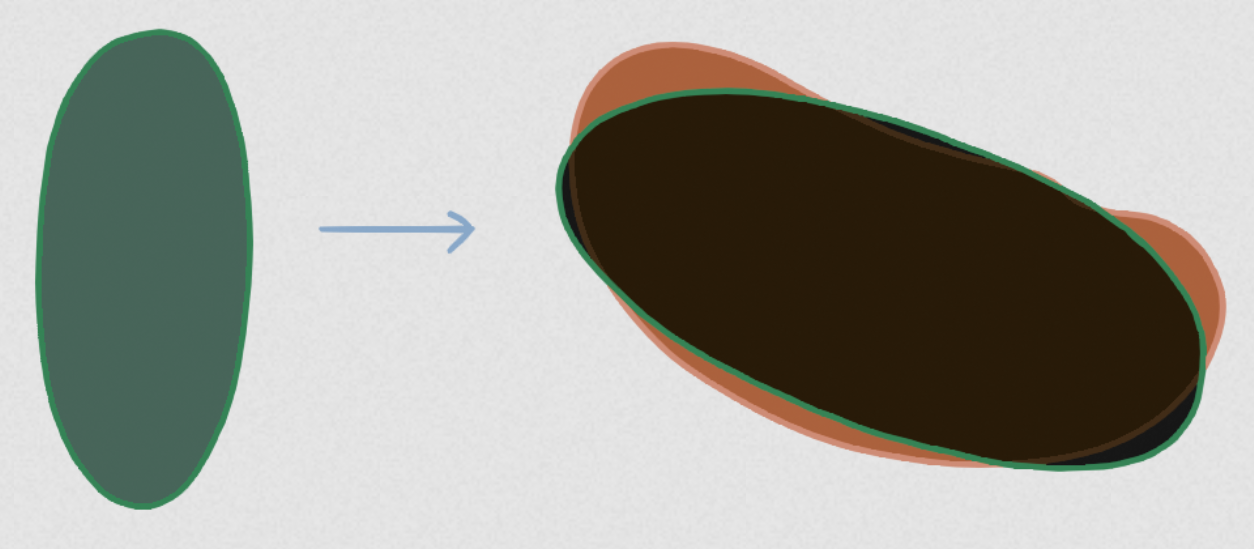

Next, the shrink-wrapping operation deforms the reference mesh to snuggly fit the target mesh:

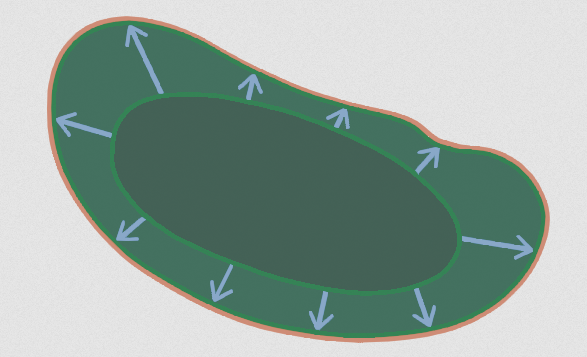

For step 1, we provide a Python module and a button in the Blender add-on. We could also use the `pymeshlab` GUI. 
For step 2, we will use the [shrinkwrap modifier](https://docs.blender.org/manual/en/latest/modeling/modifiers/deform/shrinkwrap.html) in blender. In tutorial 9, we will see how to carry out shrinkwrapping automatically from within python.

We will explain the process using the dataset in `nbs/Tutorials/wrapping_example`.

This approach works if the reference mesh and the target mesh are roughly of similar shape. If this is no longer the case - for example in a movie where the surface of interest undergoes drastic deformations - more sophisticated approaches are required. These are described in full generality in tutorial 10.

In [2]:
from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import mesh as tcmesh
from blender_tissue_cartography import remesh as tcremesh
from blender_tissue_cartography import interpolation as tcinterp
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import wrapping as tcwrap

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [3]:
import numpy as np
from skimage import transform
from scipy import stats, spatial, linalg
import os
import matplotlib.pyplot as plt

In [4]:
# this module will not be available on new ARM apple computers

import pymeshlab
from blender_tissue_cartography import remesh_pymeshlab as tcremesh_pymeshlab

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



In [5]:
np.set_printoptions(suppress=True)

## Pre-processing

### Loading and segmenting the dataset

We will use the same dataset - a _Drosophila_ example - as in tutorial 5.

In [6]:
metadata_dict = {'filename': 'wrapping_example/Drosophila_CAAX-mCherry',
                 'resolution_in_microns': (1.05, 1.05, 1.05), # lightsheet data has isotropic resolution
                 'subsampling_factors': (1/2, 1/2, 1/2),
                }

In [7]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (1, 190, 509, 188)


In [8]:
subsampled_image = tcio.subsample_image(image, metadata_dict['subsampling_factors'],
                                        use_block_averaging_if_possible=False)
print("subsampled image shape:", subsampled_image.shape)

subsampled image shape: (1, 95, 254, 94)


### Create 3d segmentation

Now create a 3d segmentation, in this case using ilatik. We use [ilastik binary pixel classification](https://www.ilastik.org/documentation/pixelclassification/pixelclassification). We could post-process the ilastik output here, for example using morphsnakes. We then load the segmentation back into the jupyter notebook.

The bright dots outside the embryo are fluorescent beads necessary for sample registration in light-sheet microscopy. You can ignore them.

Attention: when importing the `.h5` into ilastik, make sure the dimension order is correct! In this case, `czyx` for both export and import.

In [9]:
# we now save the subsampled image a .h5 file for input into ilastik for segmentation

tcio.write_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image)

In [10]:
# after creating an ilastik project, training the model, and exporting the probabilities, we load the segmentation

segmentation = tcio.read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # select the first channel of the segmentation - it's the probablity a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (95, 254, 94)


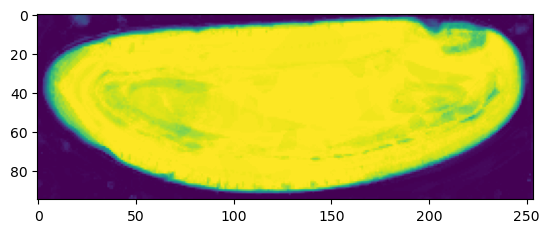

In [11]:
# look at the segmentation in a cross section

plt.imshow(segmentation[:,:,50], vmin=0, vmax=1)

### Meshing

We convert the segmentation into a triangular mesh using the marching cubes method and save the mesh as a wavefront `.obj` file.

**Important convention** For sanity's sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

In [12]:
# now we create a 3d mesh of using the marching cubes method

vertices, faces = tcremesh.marching_cubes(segmentation, isovalue=0.5, sigma_smoothing=3)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

In [13]:
mesh = tcmesh.ObjMesh(vertices_in_microns, faces)
mesh.name = "Drosophila_CAAX-mCherry_mesh_marching_cubes"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

In [14]:
# improve mesh quality using meshlab - optional

mesh_remeshed = tcremesh_pymeshlab.remesh_pymeshlab(mesh)
mesh_remeshed.write_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")

In [15]:
mesh_remeshed.vertices.shape, mesh.vertices.shape

((8434, 3), (81322, 3))

## Registration 

### Using the `blender_tissue_cartography` Python library

In the data folder, we have the mesh we just created, `Drosophila_CAAX-mCherry_mesh_remeshed.obj`, as well as out **reference mesh**  `Drosophila_reference.obj` - an idealized _Drosophila_ embryo with a standardized UV mapping, corresponding to a cylindrical projection. You can look at both meshes in the blender file `Drosophila_CAAX-mCherry.blend`.

We now register the reference mesh, i.e. bring it into approximate alignment with the data mesh. This is done in two steps (using a first, coarse alignment, and refining it using the [Iterative Closest Point algorithm](https://en.wikipedia.org/wiki/Iterative_closest_point)).

In [16]:
mesh_data = tcmesh.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")
mesh_ref = tcmesh.ObjMesh.read_obj(f"wrapping_example/Drosophila_reference.obj")

  o embryo_rect


In [17]:
trafo_initial, _ = tcreg.align_by_centroid_and_intertia(mesh_ref.vertices,
                                                        mesh_data.vertices,
                                                        scale=True, shear=True)

In [18]:
trafo_icp, _, _ = tcreg.icp(mesh_ref.vertices, mesh_data.vertices,
                            initial=trafo_initial, threshold=1e-4, max_iterations=100,
                            include_scaling=True, n_samples=5000)

In [19]:
# apply the computed transformation and save the result
mesh_registered = mesh_ref.apply_affine_to_mesh(trafo_icp)
mesh_registered.name = "Drosophila_reference_preregistered"
mesh_registered.write_obj(f"wrapping_example/Drosophila_reference_registered.obj")

### Using the `blender_tissue_cartography` add-on

You can also carry out the registration directly in Blender, using the add-on version of `blender_tissue_cartography`:

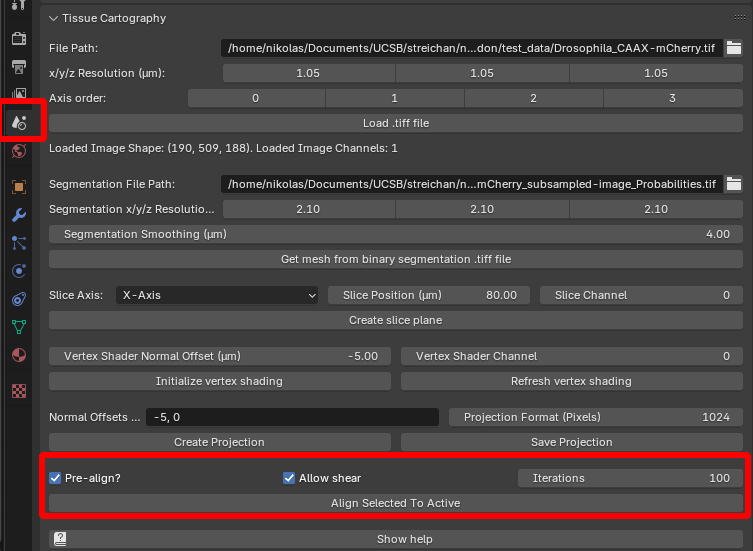


See tutorial 3.

### Using MeshLab

You can also perform registration graphically in MeshLab - see this tutorial: https://www.youtube.com/watch?v=30bJcj6yA4c. Use this if you have problems with the automated method above.

## Wrapping

### Using Blender

Now that we have registered the mesh, we can wrap it! Let's first do it using blender with the [shrinkwrap modifier](https://docs.blender.org/manual/en/latest/modeling/modifiers/deform/shrinkwrap.html). Go to the "layout" tab and click the "blue wrench" on the right to add a modifier. Search for shrinkwrap, select the target, and use "Tangent Normal Project" for best results:

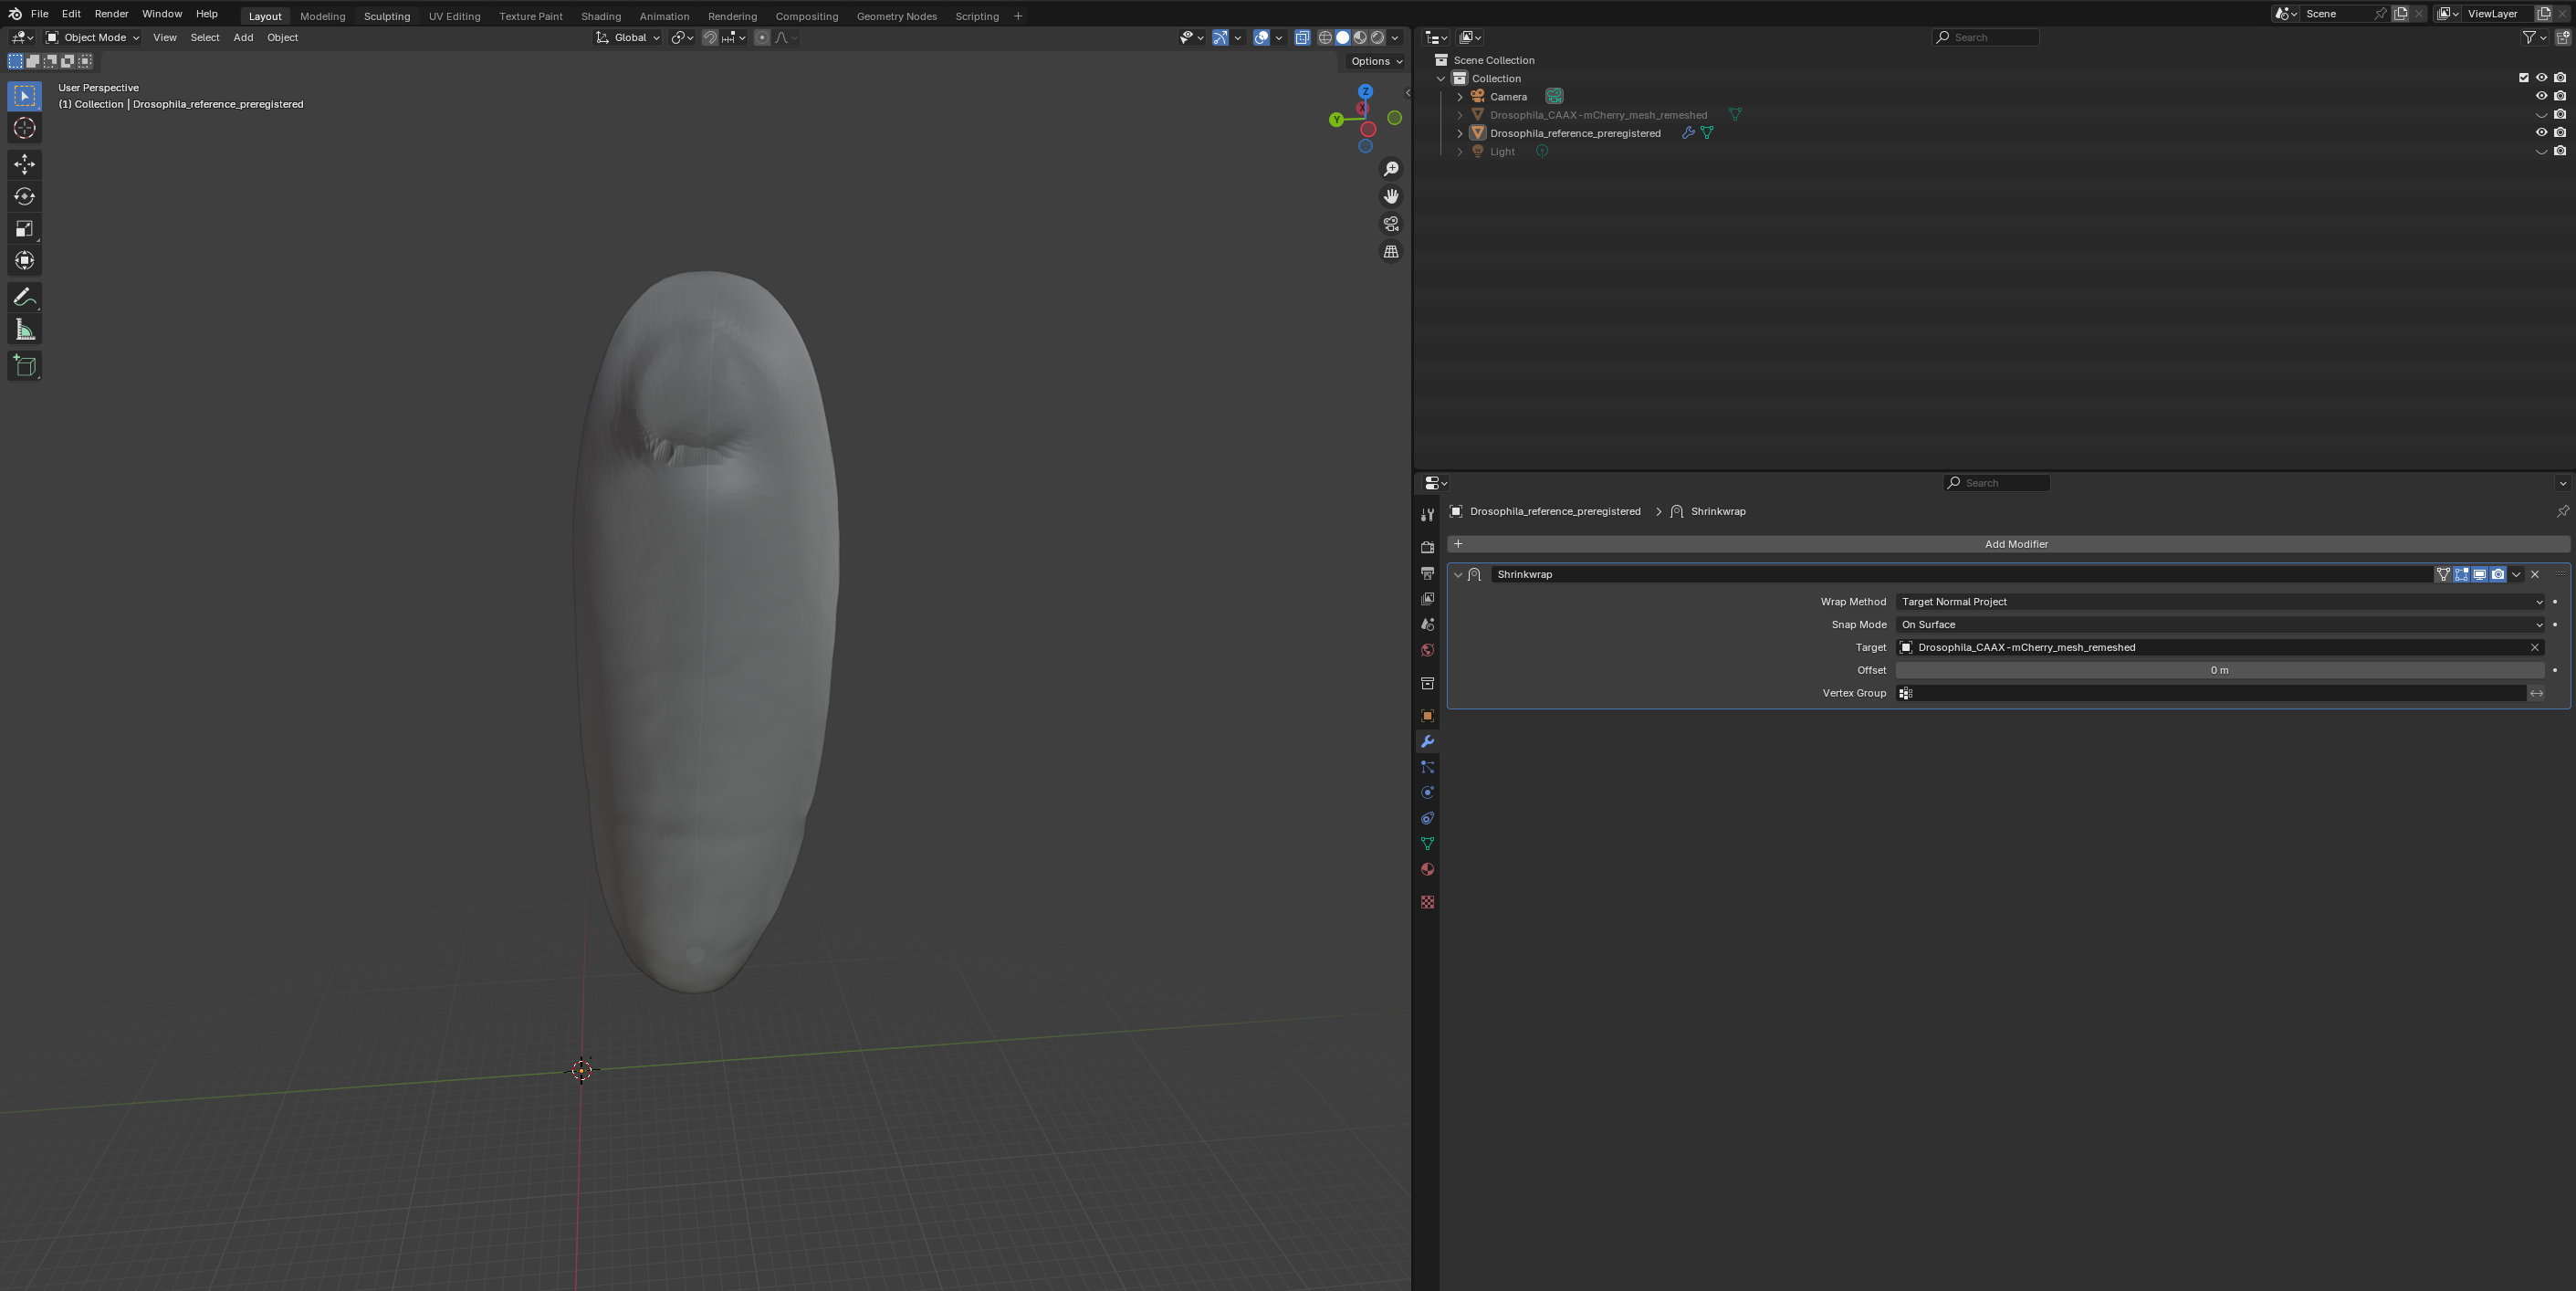

If things look good, click "Apply" to make the modifier permanent and export the mesh as `Drosophila_reference_wrapped.obj`.

### Automated wrapping using the Python library

We can also carry out the shrink-wrapping operation in Python, optionally smoothing the mesh after to remove "creases".

In [22]:
mesh_wrapped = tcwrap.shrinkwrap_igl(mesh_registered, mesh_data,  n_iter_smooth_target=1, n_iter_smooth_wrapped=1)
mesh_wrapped.write_obj(f"wrapping_example/Drosophila_reference_automated_wrapped.obj")

### Normals and normal-related problems

This may be a good point to note that if you have any problems with multilayer projections, your normals may be messed up. [Some advice](https://all3dp.com/2/blender-recalculate-normals-simply-explained/) on how to visualize and if necessary, recalculate mesh normals.

**Useful tools**: "Recalculate normals" (under "Mesh" in "Edit Mode"), and the modifier "Normals -> Weighted Normal" (smoothes normals) and "Deform -> Smooth".

Let's visualize our mesh normals on top of our image data.

In [23]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
#mesh = tcmesh.ObjMesh.read_obj(f"wrapping_example/Drosophila_reference_wrapped.obj")
mesh = tcmesh.ObjMesh.read_obj(f"wrapping_example/Drosophila_reference_automated_wrapped.obj")

#mesh = tcmesh.ObjMesh.read_obj(f"wrapping_example/Drosophila_CAAX-mCherry_mesh_remeshed_sphere_uv.obj")

resolution = metadata_dict["resolution_in_microns"]

In [24]:
slice_image, slice_vertices, slice_normals = tcinterp.get_cross_section_vertices_normals(
    1, 100, image, mesh, metadata_dict["resolution_in_microns"], width=1.5)

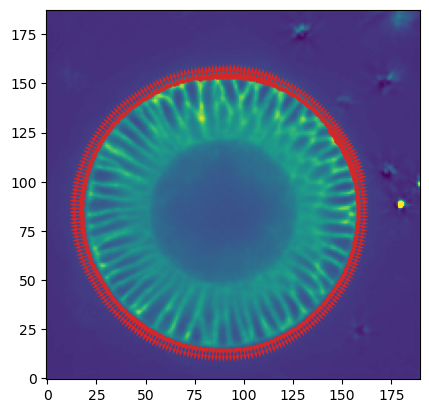

In [25]:
plt.scatter(*slice_vertices.T, s=5, c="tab:red")
plt.quiver(*slice_vertices.T, *slice_normals.T, color="tab:red")

plt.imshow(slice_image[0], vmax=10000, origin="lower") 
# normal vectors are pointing "out"

## UV projection

To see how well all of this has worked, let's use the wrapped mesh to generate UV projections. We will compare it with the automatic sphere unwrap on the original data mesh.

In [26]:
normal_offsets = np.array([-4, -2, 0, 2])
metadata_dict["normal_offsets"] = normal_offsets # add the info to the metadata
uv_grid_steps = 512

In [27]:
tcio.save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [28]:
projected_data_wrapped, projected_coordinates_wrapped, projected_normals_wrapped = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"wrapping_example/Drosophila_reference_wrapped.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

  o Drosophila_reference_wrapped_smoothed_normals
/home/nikolas/Documents/UCSB/streichan/numerics/code/python_code/jupyter_notebooks/blender-tissue-cartography/blender_tissue_cartography/interpolation.py:217: RuntimeWarning: UV map has self-intersections, 111104 flipped triangles. Try use_fallback=True?
  warnings.warn("UV map has self-intersections, {} flipped triangles. Try use_fallback=True?".format(


In [29]:
projected_data, projected_coordinates, projected_normals = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh="wrapping_example/Drosophila_CAAX-mCherry_mesh_remeshed_sphere_uv.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

  o Drosophila_CAAX-mCherry_mesh_remeshed
/home/nikolas/Documents/UCSB/streichan/numerics/code/python_code/jupyter_notebooks/blender-tissue-cartography/blender_tissue_cartography/interpolation.py:217: RuntimeWarning: UV map has self-intersections, 8 flipped triangles. Try use_fallback=True?
  warnings.warn("UV map has self-intersections, {} flipped triangles. Try use_fallback=True?".format(


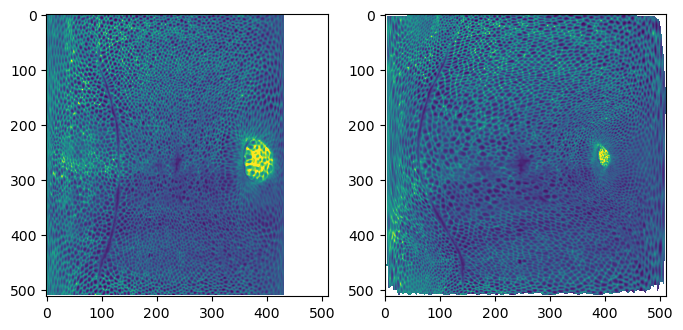

In [30]:
# show the projected data

fig, (ax1, ax2) = plt.subplots(figsize=(8,8), ncols=2)
ax1.imshow(projected_data_wrapped[0, 0], vmax=10000)
ax2.imshow(projected_data[0, 0][::-1,::-1].T, vmax=10000)

In [ ]:
# save images for visualization in blender
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures"
tcio.save_stack_for_blender(projected_data_wrapped, texture_path, normalization=(0.01, 0.99))

In [ ]:
# save images as .tif stack for analysis
tcio.save_for_imageJ(f"{metadata_dict['filename']}_projected.tif", projected_data_wrapped, z_axis=1)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_3d_coordinates.tif", projected_coordinates_wrapped)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_normals.tif", projected_normals_wrapped)

Let's add a shader to check the texture looks good:

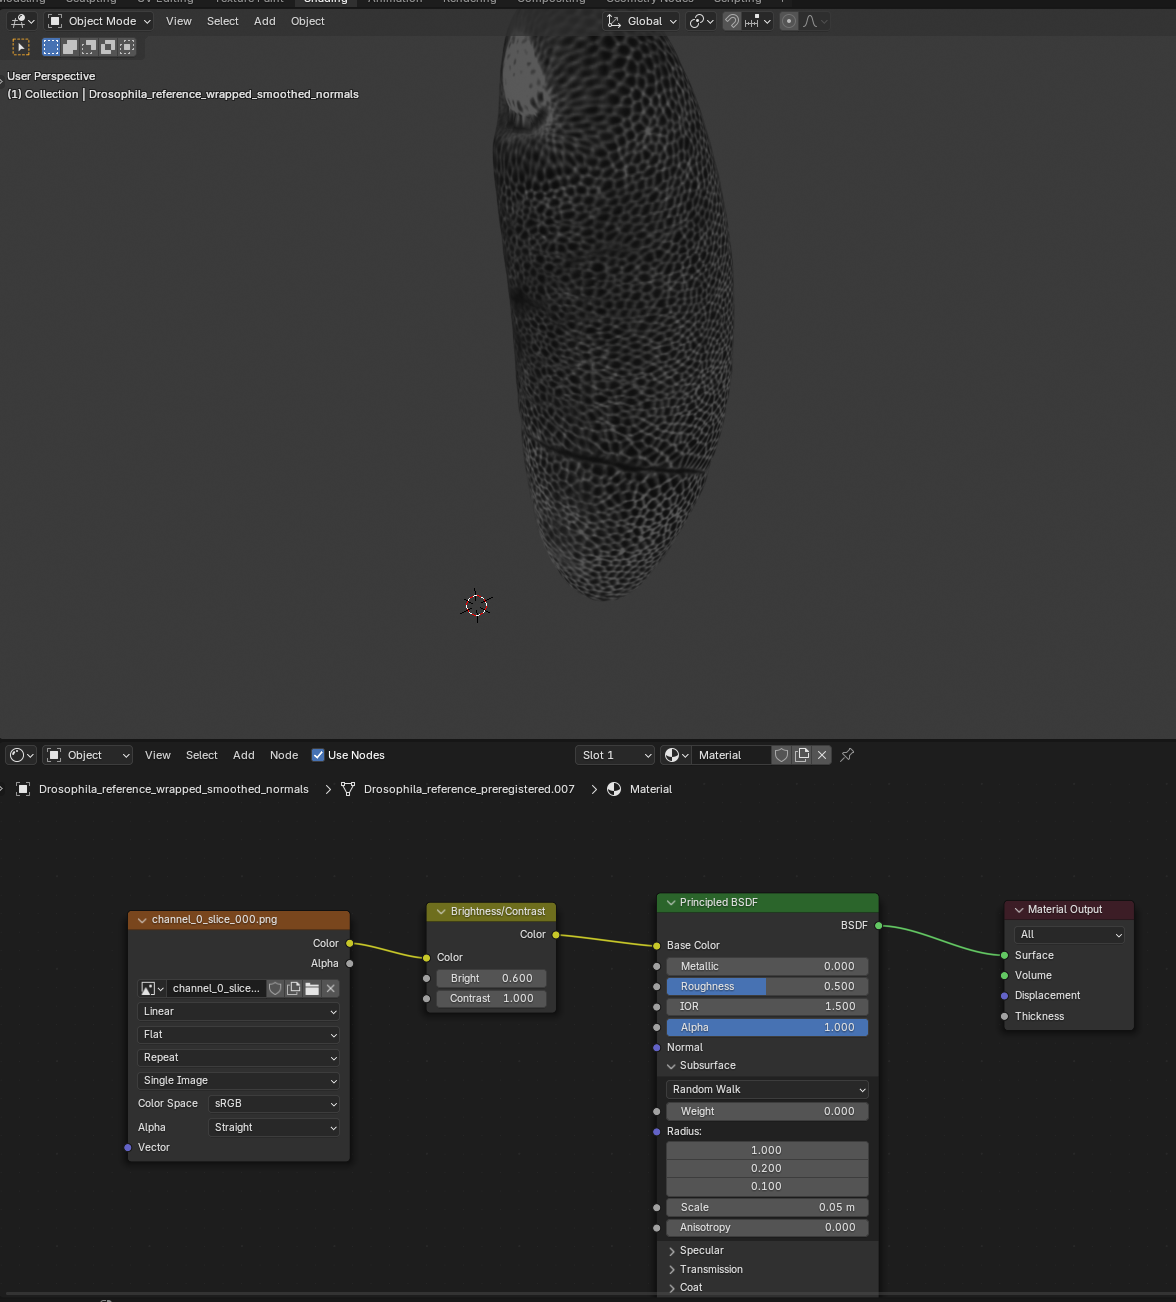
